In [1]:
from __future__ import absolute_import, division, print_function

import pprint
import argparse
import logging
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3" # Set GPU Index to use
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import random
import sys
import pickle
import copy
import collections
import math

import numpy as np
import numpy
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,TensorDataset
# from torch.utils.tensorboard import SummaryWriter

from torch.nn import CrossEntropyLoss, MSELoss
from tqdm import tqdm
from transformer import BertForSequenceClassification,WEIGHTS_NAME, CONFIG_NAME
from transformer.modeling_quant import BertForSequenceClassification as QuantBertForSequenceClassification
from transformer import BertTokenizer
from transformer import BertAdam
from transformer import BertConfig
from transformer import QuantizeLinear, QuantizeAct, BertSelfAttention, FP_BertSelfAttention, ClipLinear
from utils_glue import *
from bertviz import model_view

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F
        
def get_tensor_data(output_mode, features):
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)


    all_seq_lengths = torch.tensor([f.seq_length for f in features], dtype=torch.long)
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    tensor_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,all_label_ids, all_seq_lengths)
    return tensor_data, all_label_ids

def do_eval(model, task_name, eval_dataloader,
            device, output_mode, eval_labels, num_labels, teacher_model=None):
    eval_loss = 0
    nb_eval_steps = 0
    preds = []

    for batch_ in tqdm(eval_dataloader, desc="Inference"):
        batch_ = tuple(t.to(device) for t in batch_)
        
        with torch.no_grad():
            input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch_

            # teacher attnmap test
            if teacher_model is not None: 
                teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids, segment_ids, input_mask)
                logits, loss, cls_loss, rep_loss, output_loss, attmap_loss, attscore_loss, coeff_list, _  = model(input_ids, segment_ids, input_mask, teacher_outputs=(teacher_probs, teacher_values, teacher_reps, teacher_logits, teacher_atts), output_mode=output_mode, seq_lengths=seq_lengths)
            else:
                logits, _, _, _, _, _, _, _, _ = model(input_ids, segment_ids, input_mask)
        # create eval loss and other metric required by the task
        if output_mode == "classification":
            loss_fct = CrossEntropyLoss()
            tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
        elif output_mode == "regression":
            loss_fct = MSELoss()
            tmp_eval_loss = loss_fct(logits.view(-1), label_ids.view(-1))

        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if len(preds) == 0:
            preds.append(logits.detach().cpu().numpy())
        else:
            preds[0] = np.append(
                preds[0], logits.detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps

    preds = preds[0]
    if output_mode == "classification":
        preds = np.argmax(preds, axis=1)
    elif output_mode == "regression":
        preds = np.squeeze(preds)
    result = compute_metrics(task_name, preds, eval_labels.numpy())
    result['eval_loss'] = eval_loss
    return result

def soft_cross_entropy(predicts, targets):
    student_likelihood = torch.nn.functional.log_softmax(predicts, dim=-1)
    targets_prob = torch.nn.functional.softmax(targets, dim=-1)
    return torch.sum((- targets_prob * student_likelihood), dim=-1).mean()

processors = {
    "cola": ColaProcessor,
    "mnli": MnliProcessor,
    "mnli-mm": MnliMismatchedProcessor,
    "mrpc": MrpcProcessor,
    "sst-2": Sst2Processor,
    "sts-b": StsbProcessor,
    "qqp": QqpProcessor,
    "qnli": QnliProcessor,
    "rte": RteProcessor   
}

output_modes = {
        "cola": "classification",
        "mnli": "classification",
        "mrpc": "classification",
        "sst-2": "classification",
        "sts-b": "regression",
        "qqp": "classification",
        "qnli": "classification",
        "rte": "classification"
}

default_params = {
        "cola": {"max_seq_length": 64,"batch_size":16,"eval_step":200}, #50
        "mnli": {"max_seq_length": 128,"batch_size":32,"eval_step":1000},
        "mrpc": {"max_seq_length": 128,"batch_size":32,"eval_step":200},
        "sst-2": {"max_seq_length": 64,"batch_size":32,"eval_step":200}, #64
        "sts-b": {"max_seq_length": 128,"batch_size":32,"eval_step":50},
        "qqp": {"max_seq_length": 128,"batch_size":32,"eval_step":1000},
        "qnli": {"max_seq_length": 128,"batch_size":32,"eval_step":1000},
        "rte": {"max_seq_length": 128,"batch_size":16,"eval_step":5000} # 100
    }

## GLUE Task

In [2]:
task_name = "cola"
bert_size = "large"

if bert_size == "large":
    layer_num = 24
    head_num = 16
else: 
    layer_num = 12
    head_num = 12

## Dataset

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "models"
output_dir = "output"

if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

teacher_model_dir = os.path.join(model_dir,task_name)

# Processor & Task Info
processor = processors[task_name]()
output_mode = output_modes[task_name]
label_list = processor.get_labels()
num_labels = len(label_list)

if task_name in default_params:
    batch_size = default_params[task_name]["batch_size"]
    max_seq_length = default_params[task_name]["max_seq_length"]
    eval_step = default_params[task_name]["eval_step"]
    
# Tokenizer
tokenizer = BertTokenizer.from_pretrained(teacher_model_dir, do_lower_case=True)


# Load Dataset
data_dir = os.path.join("data",task_name)
processed_data_dir = os.path.join(data_dir,'preprocessed')

train_examples = processor.get_train_examples(data_dir)

train_features = convert_examples_to_features(train_examples, label_list,
                                max_seq_length, tokenizer, output_mode)

train_features = train_features[:int(len(train_features))]
print(f"Num examples = {len(train_features)}")

train_data, train_labels = get_tensor_data(output_mode, train_features)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# eval_examples = processor.get_dev_examples(data_dir)
# eval_features = convert_examples_to_features(eval_examples, label_list, max_seq_length, tokenizer, output_mode)
# # dev_file = train_file = os.path.join(processed_data_dir,'dev.pkl') 
# # eval_features = pickle.load(open(dev_file,'rb'))

# eval_data, eval_labels = get_tensor_data("classification", eval_features)
# eval_sampler = SequentialSampler(eval_data)
# eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)
# eval_data, eval_labels = get_tensor_data(output_mode, eval_features)

# eval_examples = processor.get_dev_examples(data_dir)

05/17 03:27:06 AM Writing example 0 of 8551
05/17 03:27:06 AM *** Example ***
05/17 03:27:06 AM guid: train-0
05/17 03:27:06 AM tokens: [CLS] our friends won ' t buy this analysis , let alone the next one we propose . [SEP]
05/17 03:27:06 AM input_ids: 101 2256 2814 2180 1005 1056 4965 2023 4106 1010 2292 2894 1996 2279 2028 2057 16599 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
05/17 03:27:06 AM input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
05/17 03:27:06 AM segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
05/17 03:27:06 AM label: 1
05/17 03:27:06 AM label_id: 1
Num examples = 8551


## Load Model

In [5]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
mse_func = MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "models"
output_dir = "output"

if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

student_model_dir = os.path.join(model_dir,task_name)
teacher_model_dir = os.path.join(model_dir,task_name)
# # Teacher Model Build

# teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
# teacher_model.to(device)
# teacher_model.eval()

# Student Model Build - Normal Init
quant_model_name = "1SB_map_O"
sarq_model_name = "sarq_step1_ci_O"

quant_model_dir = os.path.join(output_dir, task_name, "exploration", quant_model_name)  
sarq_model_dir = os.path.join(output_dir, task_name, "exploration", sarq_model_name)  
normal_init_dir = os.path.join(model_dir,task_name)

quant_config = BertConfig.from_pretrained(quant_model_dir)             

normal_model = QuantBertForSequenceClassification.from_pretrained(normal_init_dir, config = quant_config, num_labels=num_labels)
normal_model.to(device)
sarq_model = QuantBertForSequenceClassification.from_pretrained(sarq_model_dir, config = quant_config, num_labels=num_labels)

normal_model.to(device)
sarq_model.to(device)

normal_model.eval()
sarq_model.eval()

print()
print("==> Load Model DONE")
print("==> Test Inference")


05/17 03:27:32 AM loading configuration file output/BERT_large/cola/exploration/1SB_map_O/config.json
05/17 03:27:38 AM Loading model models/BERT_large/cola/pytorch_model.bin
05/17 03:27:39 AM loading model...
05/17 03:27:39 AM done!
05/17 03:27:39 AM Weights from pretrained model not used in BertForSequenceClassification: ['bert.embeddings.position_ids']
05/17 03:27:46 AM Loading model output/BERT_large/cola/exploration/sarq_step1_ci_O/pytorch_model.bin
05/17 03:27:47 AM loading model...
05/17 03:27:47 AM done!
05/17 03:27:47 AM Weights from pretrained model not used in BertForSequenceClassification: ['coeff']

==> Load Model DONE
==> Test Inference


In [6]:
if output_mode == "classification":
    loss_fct = CrossEntropyLoss()

elif output_mode == "regression":
    loss_fct = MSELoss()


In [10]:
from hessian import hessian
from tqdm import tqdm

tc_max_eigens = []
for batch in tqdm(train_dataloader):
    input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch
    hessian_comp = hessian(normal_model, data=(input_ids, label_ids), criterion=loss_fct, cuda=True, input_zip = (input_ids, segment_ids, input_mask))
    top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=5)
    tc_max_eigens = tc_max_eigens + top_eigenvalues

print("==> Teacher Model Eigen Value DONE!")
# st_max_eigens = []
# for batch in tqdm(train_dataloader):
#     input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch
#     hessian_comp = hessian(student_model, data=(input_ids, label_ids), criterion=loss_fct, cuda=True)
#     top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=5)
#     st_max_eigens = st_max_eigens + top_eigenvalues
# print("==> Student Model Eigen Value DONE!")

  0%|▋                                                                                                                                                                                                                                                                                                                                                                               | 1/535 [03:21<29:57:28, 201.96s/it]


KeyboardInterrupt: 

## Plot KDE Max Eigenvalues density

In [55]:
pos_eigens = []
neg_eigens = []
for eigen in tc_max_eigens:
    if eigen > 0:
        pos_eigens.append(eigen)
    else:
        neg_eigens.append(eigen)

<AxesSubplot:ylabel='Density'>

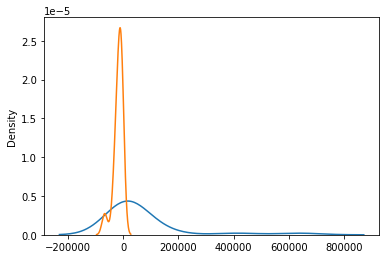

In [56]:
import seaborn as sns
sns.kdeplot(pos_eigens)
sns.kdeplot(neg_eigens)
# tc_max_eigens